# 0.0 Business Context

**Desafio**

Criar um modelo de alta performance na identificação de clientes em churn.

Sobre a Empresa:
A TopBottonBank é um novo banco com atuação na europa.
 
**Entregável:**
Ao final da sua consultoria, você precisa entregar ao CEO da TopBottomBank um modelo em produção, que receberá uma base de clientes via API e desenvolverá essa base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Perguntas a serem respondidas no report final:
1-Qual a taxa de Churn atual da empresa?
2-Como a taxa de Churn varia por mês?
3-Qual a Performance do modelo em classificar os clientes como churns?
4-Qual o Faturamento da empresa, se ela impedir que os clientes de entrar em Churn através do seu modelo?
5-Qual o valor de um cupom de desconto você daria para o cliente, a fim de evitar churn? E qual o custo total desse incentivo para a empresa?

**Index:**
 - 0.0 Problema de Negócio
 - 0.1 Importações de bibliotecas
 - 1.0 Coleta de Dados
 - 2.0 Descrição dos Dados
 - 3.0 Limpeza de dados
 - 4.0 Feature Engineering
 - 5.0 EDA
 - 6.0 Teste de Hipóteses
 - 7.0 Split de Dados
 - 8.0 Data Preparation
 - 9.0 Feature Selection
 - 10.0 Model Selection
 - 11.0 Tunning/Treinamento do modelo
 - 12.0 Interpretação dos Modelos
 - 13.0 API
 
**Estrátegia:**

1.0 Coleta de Dados:
Coletar os dados utilizando pd.read_csv().

2.0 Descrição dos Dados:
- Descrever as seguintes infos por feature: percentual de missing, valores únicos,     percentual de valores únicos, tipos de dados, skew, kurtosis.
- Descrever Gender vs Exited.
- Descrever Geography vs Exited.
- Descrever HasCrCard vs Exited 
- Descrever IsActiveMember vs Exited
- Descrever a variável 'type' com relação ao target.
- Descrever outras variáveis conforme for pertinente.
- Investigar a presença de Outliers.

3.0 Limpeza de dados:
- Eliminar os outliers utilizando a tecnica IQR.

4.0 Feature Engineering:
- Eliminar as variáveis RowNumber, CustomersId, Surname(granularidade alta) por apresentarem pouco ganho de informação para a modelagem do nosso problema.
- Criar variável com Kmeans usando k=2. O valor de k é devido a estarmos trabalhando com um problema binário.
- Criar variável EstimatedSalary por location. Distribuição da renda podem nos ajudar na modelagem do problema.
- Binning as variáveis CreditScore, Age, Tenure, Balance, EstimatedSalary. Realizando o Binning dessas variáveis diminuimos a granularidade das mesmas o que irá facilitar a modelagem do problema futuramente.
- Criar a variável LTV - Life Time Value, através da divisão de Balance por Tenure.

5.0 EDA:
 - Realizar análise Univariada.
 - Realizar análise Multivariada.

6.0 Teste de Hipoteses:
 - H1 - O 'Balance' é maior acima de 30 anos de idade.
 - H2 - O 'Balance' é maior entre os clientes homens que mulheres.
 - H3 - O 'EstimatedSalary' é maior entre clientes homens que mulheres.
 - H4 - O 'EstimatedSalary' é maior acima de 30 anos de idade.
 - H5 - O churn é maior entre os menbros inativos que os ativos.

7.0 Split de Dados:
- Separar aleatoriamente 10% dos dados para dados de treino.

8.0 Data Preparation:
- Para a preparação dos dados iremos utilizar Ordinal Encoder sobre as variáveis categóricas and RobustScaler sobre as variáveis númericas.
- Iremos também balanciar os nosso dados utilizando uma tecnica hibrida entre over e under-sampling chamada SMOTETomeklink. A mesma consiste no under-sampling dos dados na fronteira das classes com o over-sampling dos dados mais afastados, o que gera uma maior separação entre as classes por essa razão a escolha por essa tecnica. 

9.0 Feature Selection:
 - A seleção de Features aplicaremos o algoritmo Boruta-Shap, que é um seletor do tipo wrapper que utilizara um modelo RandomForest() e shap values para selecionar as melhores variáveis.
 
10.0 Model Selection:
 - O modelo será selecionado conforme o recall, pois estamos trabalhando em problema binário cujo a classe positiva é um evento raro (churn) outra metrica que usaremos será a f1 que consiste na média harmonica entre o recall e a precision. A f1 nos indicara como esta o equilibrio do modelo em prever corretamente a tanto a classe positiva quanto a negativa.

11.0 Tunning/Treinamento do modelo:
- Será realiazado o tunning e o tranamento do ou dos modelos selecionados na etapa anterior.

12.0 Interpretação dos Modelos:
- Iremos interpretar os modelo utilizando matriz de confusão -com o objetivo de entender onde o modelo está errando-, learning_curves-para entendermos como está ocorrendo a convergência-, feature_importance -para entermos quais variaveis estão sendo mais relevantes na reslução do problema.

13.0 API:
- Servir o modelo através de uma API.


**Resultados**



# 0.1 Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV 
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Models
import lightgbm as lgb
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hipo Test
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score, f1_score, recall_score

## Helper Functions

In [2]:
def multi_boxplots(df, variables: list) -> None:

    """
    Function to check for outliers visually through a boxplot

    data: DataFrame

    variable: list of numerical variables
    """

    # set of initial plot posistion
    n = 1

    plt.figure(figsize=(18, 10))
    for column in df[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.boxplot(x=column, data=df)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()
    
def Myheat_map(dataset, variaveis):
    
    """
    
    
    """

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()

def cramer_v(var_x, var_y):
    """
    Function to calculate the Cramers v correlation.

    """
    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p

def learning_curves(estimator, features, target, train_sizes, cv):
    
    """
    
    """

    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes =
    train_sizes,
    cv = cv, scoring = 'recall')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('Recall', fontsize = 12)
    plt.xlabel('Training set size', fontsize = 12)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 14, y = 1.03)
    plt.legend()

def model_selection(X,y):
    
    """
    
    """
    
    # Modelos
    models = [('lr',LogisticRegression(),1),
              ('svm',SVC(),2),
              ('dt',DecisionTreeClassifier(),3),
              ('rf', RandomForestClassifier(),4),
              ('lgb',lgb.LGBMClassifier(),5),
              ('xgboost', XGBClassifier(),6)]

    # Resultados
    resultados = {'LR': [],
                  'SVM': [],
                  'DecisionTree': [],
                  'RandomForestClassifier': [],
                  'LGBM': [],
                  'XGBOOST': []}

    # Testando algoritmos
    for name, model,_ in models:
        
        # cross-validação
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        
        # resultado
        resultado = cross_val_score(estimator=model,
                                    X=X,
                                    y=y,
                                    scoring='recall',
                                    cv=cv,
                                    n_jobs=-1)

        if name == 'lr':
            resultados['LR'].append(np.mean(resultado))
        elif name == 'knn':
            resultados['KNN'].append(np.mean(resultado)) 
        elif name == 'svm':
            resultados['SVM'].append(np.mean(resultado))
        elif name == 'dt':
            resultados['DecisionTree'].append(np.mean(resultado))
        elif name == 'rf':
            resultados['RandomForestClassifier'].append(np.mean(resultado))
        elif name == 'lgb':
            resultados['LGBM'].append(np.mean(resultado))
        elif name == 'xgboost':
            resultados['XGBOOST'].append(np.mean(resultado))
        
    # train_sizes
    train_sizes = list(np.arange(1, 10832, 2000))

    # Croos-Validação
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # Plot das curvas de aprendizagem
    plt.figure(figsize = (20,15))
    for _, model, i in models:
        plt.subplot(2,3,i)
        learning_curves(estimator=model, features=Xtrain_smt, target=ytrain_smt, train_sizes=train_sizes, cv=5)
        plt.subplots_adjust(hspace=0.3)

    # Painel
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

# 1.0 Data Colection

In [3]:
churn = pd.read_csv('data/churn.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2.0 Data Description

**Book de Variáveis:**

Age: Idade do cliente.

Balance: Quantidade de dinheiro na

CreditScore: Score de crédito do cliente.

CustomerId: Identificador unico do cliente.

EstimatedSalary: Salário estimado do cliente.

Exited: Variável target se ocorreu ou não churn do cliente.

Gender: Genêro do cliente.

Geography: Localizaçao do cliente.

HasCrCard: Flag se o cliente possui um cartão de crédito ou não

IsActiveMember: Flag se o cliente é ativo ou não.

RowNumber: Número da linha no dataset.

Surname: Sobrenome do cliente.

Ternure: Quantidade em anos que o cliente ainda está no banco ( no-churn ) e ela também diz quanto tempo o cliente ficou no banco até o churn.

In [4]:
# Describe
pd.DataFrame({'missing' :churn.isna().mean(),
              'uniques' :churn.nunique(),
              'dtypes'  :churn.dtypes,
              'min'     :churn.min(),
              'mean'    :churn.mean(),
              'median'  :churn.median(),
              'max'     :churn.max(),
              'skew'    :churn.skew(),
              'kurtosis':churn.kurtosis()})

,missing,uniques,dtypes,min,mean,median,max,skew,kurtosis
Age,0.0,70,int64,18,3.892180e+01,3.700000e+01,92,1.011320,1.395347
Balance,0.0,6382,float64,0,7.648589e+04,9.719854e+04,250898,-0.141109,-1.489412
CreditScore,0.0,460,int64,350,6.505288e+02,6.520000e+02,850,-0.071607,-0.425726
CustomerId,0.0,10000,int64,15565701,1.569094e+07,1.569074e+07,15815690,0.001149,-1.196113
EstimatedSalary,0.0,9999,float64,11.58,1.000902e+05,1.001939e+05,199992,0.002085,-1.181518
Exited,0.0,2,int64,0,2.037000e-01,0.000000e+00,1,1.471611,0.165671
Gender,0.0,2,object,Female,NaN,NaN,Male,NaN,NaN
Geography,0.0,3,object,France,NaN,NaN,Spain,NaN,NaN
HasCrCard,0.0,2,int64,0,7.055000e-01,1.000000e+00,1,-0.901812,-1.186973
IsActiveMember,0.0,2,int64,0,5.151000e-01,1.000000e+00,1,-0.060437,-1.996747


 - Temos dados de diferentes escalas
 - 'Customerid' e 'RowNumber' é um idientificador único podemos eliminar ou utiliza-lo como index do dataframe.
 - As variáveis 'HasCrCard' 'IsActiveMember' são categoricas ordinais iremos alterar o seu tipo para category.

## Target - Exited

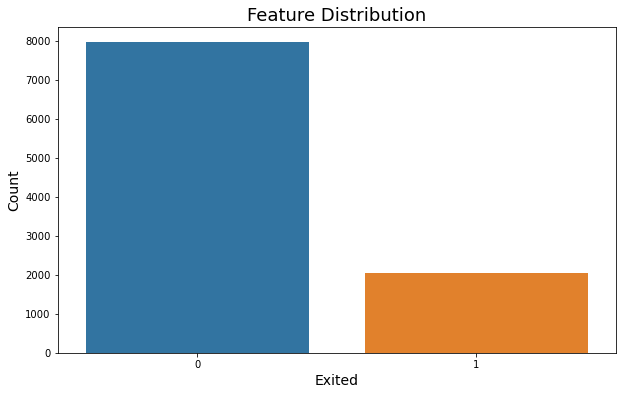

In [5]:
# Checkando o balanciamento da variável Target
ax = sns.countplot(x='Exited', hue=None, data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Exited', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Podemos observar que as classes da variável Target esta desbalanciada.

## Descrever Gender vs Exited

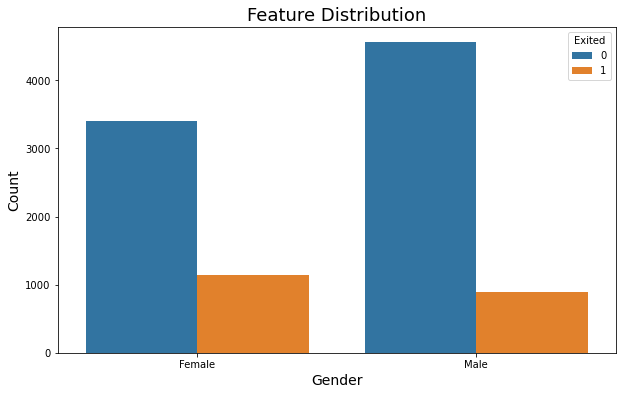

In [6]:
ax = sns.countplot(x='Gender', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

 - Aparentemente não existe uma concentração do evento de 'Churn' conforme o genero.

## Descrever Geography vs Exited

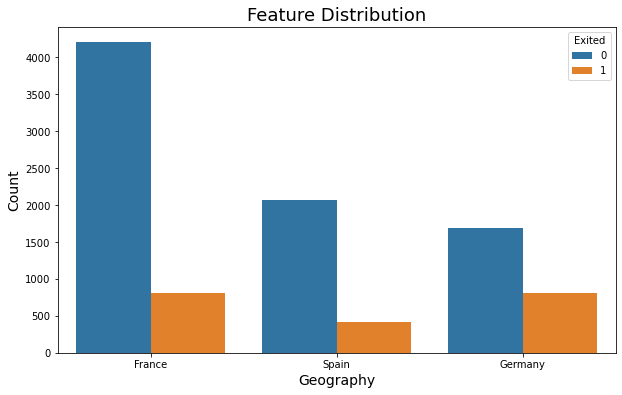

In [7]:
ax = sns.countplot(x='Geography', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('Geography', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [8]:
# Percentual de observações por valores Geography
churn.groupby('Geography').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

Geography
France     50.14
Germany    25.09
Spain      24.77
Name: RowNumber, dtype: float64

- Notamos que proporcionalmente parece ocorrer um maior churn de clientes da Alemanha. A mesma possui comente 25% das observações porém possui mais eventos churn que as demais categorias.

## Descrever HasCrCard vs Exited

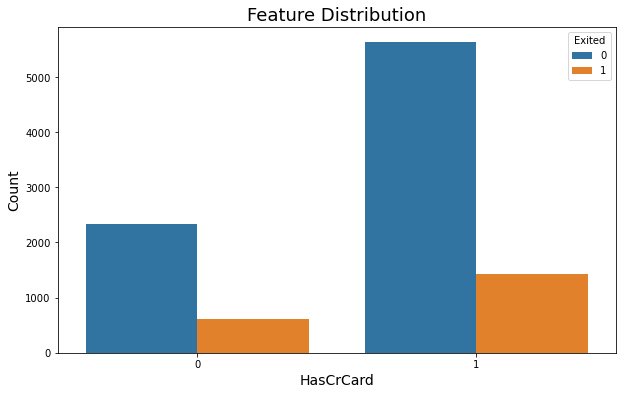

In [9]:
ax = sns.countplot(x='HasCrCard', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('HasCrCard', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [10]:
# Percentual de observações por valores HasCrCard
churn.groupby('HasCrCard').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

HasCrCard
0    29.45
1    70.55
Name: RowNumber, dtype: float64

- Devido a maior concentração de obseravções com cartão de credito temos também maior numero de eventos de churn.

## Descrever IsActiveMember vs Exited

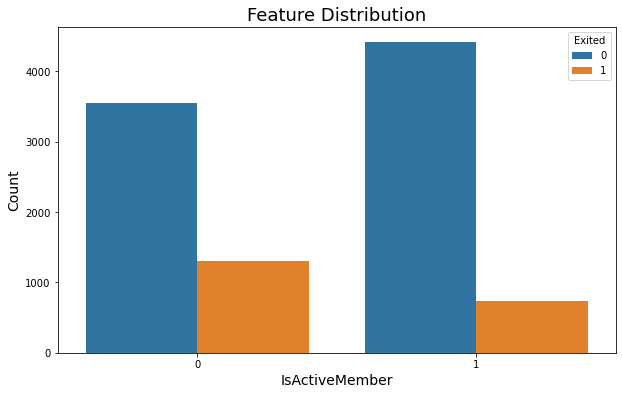

In [11]:
ax = sns.countplot(x='IsActiveMember', hue='Exited', data=churn)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Distribution', fontsize=18, loc='center')
ax.set_xlabel('IsActiveMember', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [12]:
# Percentual de observações por valores HasCrCard
churn.groupby('IsActiveMember').count()['RowNumber'].apply(lambda x: (x/churn.shape[0])*100)

IsActiveMember
0    48.49
1    51.51
Name: RowNumber, dtype: float64

 - Em um primeiro momento notamos que a inatividade leva a um maior churn. Os eventos estão distribuídos porém com maior quantidade de eventos de churn na categoria de inatividade.

## Alterando os tipos das variáveis 'HasCrCard', 'IsActiveMember', Exited

In [13]:
# Alterando o tipo de dados para category
colunas = ['HasCrCard','IsActiveMember', 'Exited', 'Surname', 'Geography','Gender']

for col in colunas:
    churn[col] = churn[col].astype('category')

In [14]:
# checkando os tipos
churn.dtypes

RowNumber             int64
CustomerId            int64
Surname            category
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard          category
IsActiveMember     category
EstimatedSalary     float64
Exited             category
dtype: object

## Checkando a Presença de Outliers

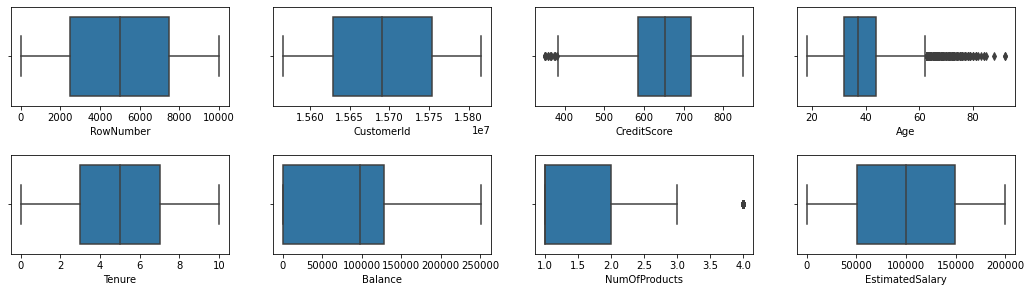

In [15]:
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

 - Observamos Outliers nas variáveis 'CreditScore', 'Age','NumOfProducts'

### CreditScore

In [16]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['CreditScore'], .25)
Q3 = np.quantile(churn['CreditScore'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

O limite inferior é 383.0
O limite superior é 919.0


 - Filtrando somente o limite inferior, pois no boxplot observamos outliers somente no limite inferior.

### Age

In [17]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(churn['Age'], .25)
Q3 = np.quantile(churn['Age'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'O limite inferior é {low}')
print(f'O limite superior é {high}')

O limite inferior é 14.0
O limite superior é 62.0


 - Filtrando somente o limite superior, pois no boxplot observamos outliers somente no limite superior.

### NumOfProducts

Iremos filtrar todas as observações com 4 produtos, pois conforme o boxplot os outliers estão nesse patamar.

# 3.0 Limpeza de Dados

 ## 3.1 Cleaning Outliers.

In [5]:
# Filtrando 'CreditScore' somente o limite inferior.
churn = churn.loc[churn['CreditScore']>400, ]

# Filtrando 'Age' somente o limite inferior
churn = churn.loc[churn['Age']<59, ]

# Filtrando 'NumOfProducts'
churn = churn.loc[churn['NumOfProducts']<4, ]

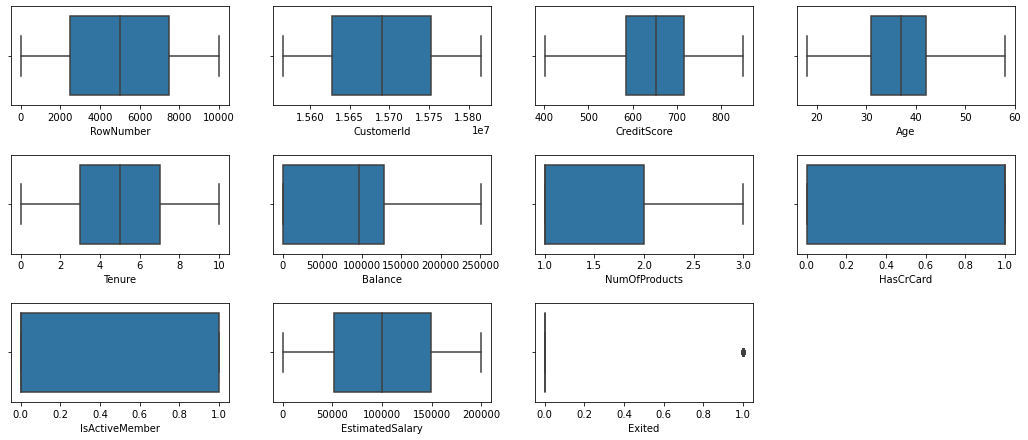

In [6]:
# checking the outliers again.
# Variáveis
variables = churn.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in churn[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=churn)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

# 4.0 Feature Engineering

- Eliminar as variáveis RowNumber, CustomersId, Surname(granularidade alta) por apresentarem pouco ganho de informação para a modelagem do nosso problema.
- Criar variável com Kmeans usando k=2. O valor de k é devido a estarmos trabalhando com um problema binário.
- Criar variável EstimatedSalary por location. Distribuição da renda podem nos ajudar na modelagem do problema.
- Binning as variáveis CreditScore, Age, Tenure, Balance, EstimatedSalary. Realizando o Binning dessas variáveis diminuimos a granularidade das mesmas o que irá facilitar a modelagem do problema futuramente.
- Criar a variável LTV - Life Time Value, através da divisão de Balance por Tenure.

In [7]:
# Copia do dataset original
dataset = churn.copy()

In [8]:
# Eliminando RowNumber, CustomersId, Surname(granularidade alta)
dataset.drop(['RowNumber','CustomerId','Surname'], inplace=True, axis=1)

In [9]:
# Variável kmeans distancia eucliadiana
# Criando copia
churn_temp = dataset.copy()

# Encoder
enc = OrdinalEncoder()
churn_temp['Gender'] = churn_temp['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
churn_temp['Geography'] = enc.fit_transform(np.array(churn_temp['Geography']).reshape(-1,1))

# kmeans model
model = KMeans(n_clusters=2,init='k-means++')
model.fit(churn_temp)
dataset['kmeans_group'] = model.labels_
dataset['kmeans_group'] = dataset['kmeans_group'].astype('category')
dataset['kmeans_group'] = dataset['kmeans_group'].apply(lambda x: 'G1' if x==1 else 'G2')

In [9]:
# Criar variável Balance por location
group_balance = dataset.groupby('Geography').agg({'Balance': ['mean']}).reset_index()
group = pd.concat([group_balance['Geography'],group_balance['Balance']['mean']], axis=1)
group = group.rename(columns={"mean":"balance_mean_geo"})
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [10]:
# Criar variável EstimatedSalary por location
group_EstimatedSalary = dataset.groupby('Geography').agg({'EstimatedSalary': ['mean']}).reset_index()
group = pd.concat([group_EstimatedSalary['Geography'],  group_EstimatedSalary['EstimatedSalary']['mean']], axis=1)
group = group.rename(columns={"mean":"EstimatedSalary_mean_geo"})
dataset = dataset.merge(group, left_on='Geography', right_on='Geography', how='inner')

In [11]:
# Criar variável EstimatedSalary por gender
group_Gender = dataset.groupby('Gender').agg({'EstimatedSalary': ['mean']}).reset_index()
group = pd.concat([group_Gender['Gender'],  group_Gender['EstimatedSalary']['mean']], axis=1)
group = group.rename(columns={"mean":"EstimatedSalary_mean_gender"})
dataset = dataset.merge(group, left_on='Gender', right_on='Gender', how='inner')

In [12]:
# Criar variável EstimatedSalary por hascrcard
group_HasCrCard = dataset.groupby('HasCrCard').agg({'EstimatedSalary': ['mean']}).reset_index()
group = pd.concat([group_HasCrCard['HasCrCard'],  group_HasCrCard['EstimatedSalary']['mean']], axis=1)
group = group.rename(columns={"mean":"group_HasCrCard_mean"})
dataset = dataset.merge(group, left_on='HasCrCard', right_on='HasCrCard', how='inner')

In [13]:
# Criar variável CreditScore score por Hascrcard
group_hascrcard = dataset.groupby('HasCrCard').agg({'CreditScore': ['mean']}).reset_index()
group = pd.concat([group_hascrcard['HasCrCard'],  group_hascrcard['CreditScore']['mean']], axis=1)
group = group.rename(columns={"mean":"hascrcard_mean_credit"})
dataset = dataset.merge(group, left_on='HasCrCard', right_on='HasCrCard', how='inner')

In [14]:
# Criar variável CreditScore score por Gender
group_gender = dataset.groupby('Gender').agg({'CreditScore': ['mean']}).reset_index()
group = pd.concat([group_gender['Gender'],  group_gender['CreditScore']['mean']], axis=1)
group = group.rename(columns={"mean":"gender_mean_credit"})
dataset = dataset.merge(group, left_on='Gender', right_on='Gender', how='inner')

In [26]:
# # Binning
# # CreditScore
# dataset['CreditScore_new'] = pd.qcut(dataset['CreditScore'],q=5)

# # Age
# dataset['Age_new'] = pd.qcut(dataset['Age'],q=5)

# # Tenure
# dataset['Tenure_new'] = pd.qcut(dataset['Tenure'],q=5)

# # Balance
# dataset['Balance_new'] = pd.qcut(dataset['Balance'],q=[.35, .70, 1])

# # EstimatedSalary
# dataset['EstimatedSalary_new'] = pd.qcut(dataset['EstimatedSalary'],q=5)

In [15]:
# Criar variável LTV
balance = dataset['Balance'].astype('int64')
dataset['LTV'] = balance / (dataset['Tenure'] + 0.1)

In [10]:
# Dando uma olhada como ficou o dataset
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,kmeans_group
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,G1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,G2
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,G2
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,G1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,G2


# 5.0 EDA

## 5.1 Análise Univariada

### Variáveis Categóricas

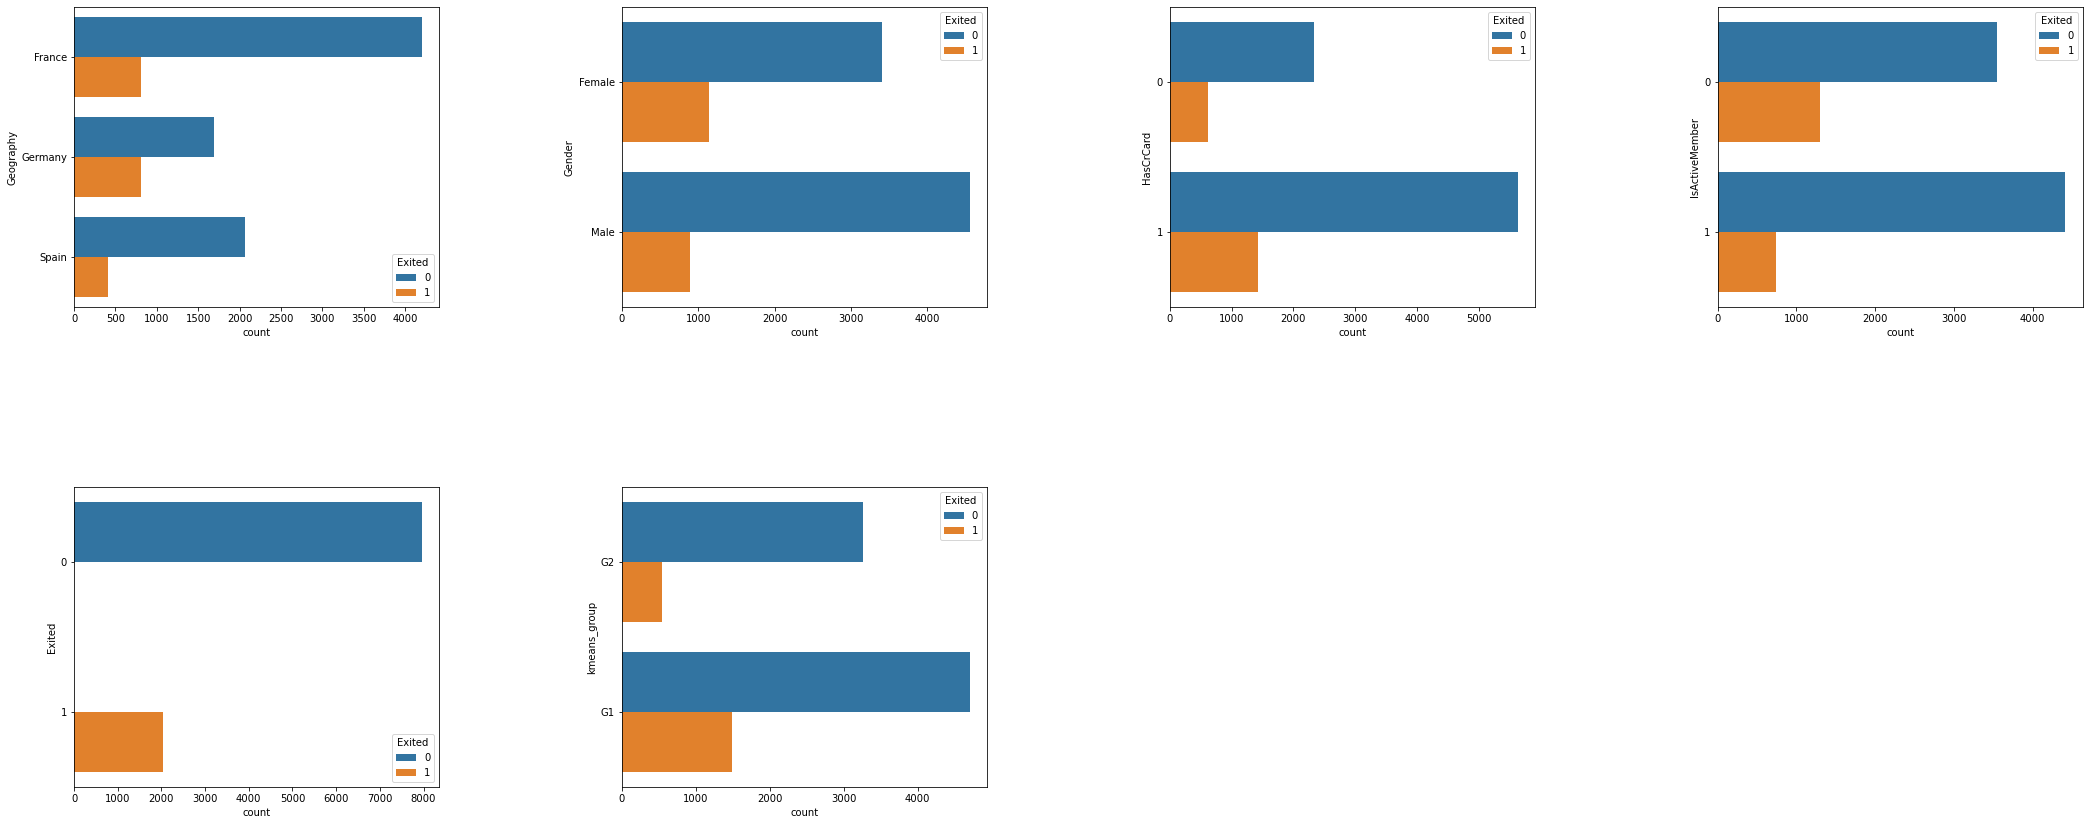

In [35]:
# checking the outliers again.
# Variáveis
variables = dataset.select_dtypes(['category']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=column,hue='Exited', data=dataset)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Os casos de churn paracem diminuir a medida que aumenta a variável 'Ternure'
- Os casos de churn parecem aumentar a medida que a idade dos clientes também aumenta.
- Outro ponto parece haver um maior concetração de churn entre os clientes que não estão ativos.

### Variáveis Númericas.

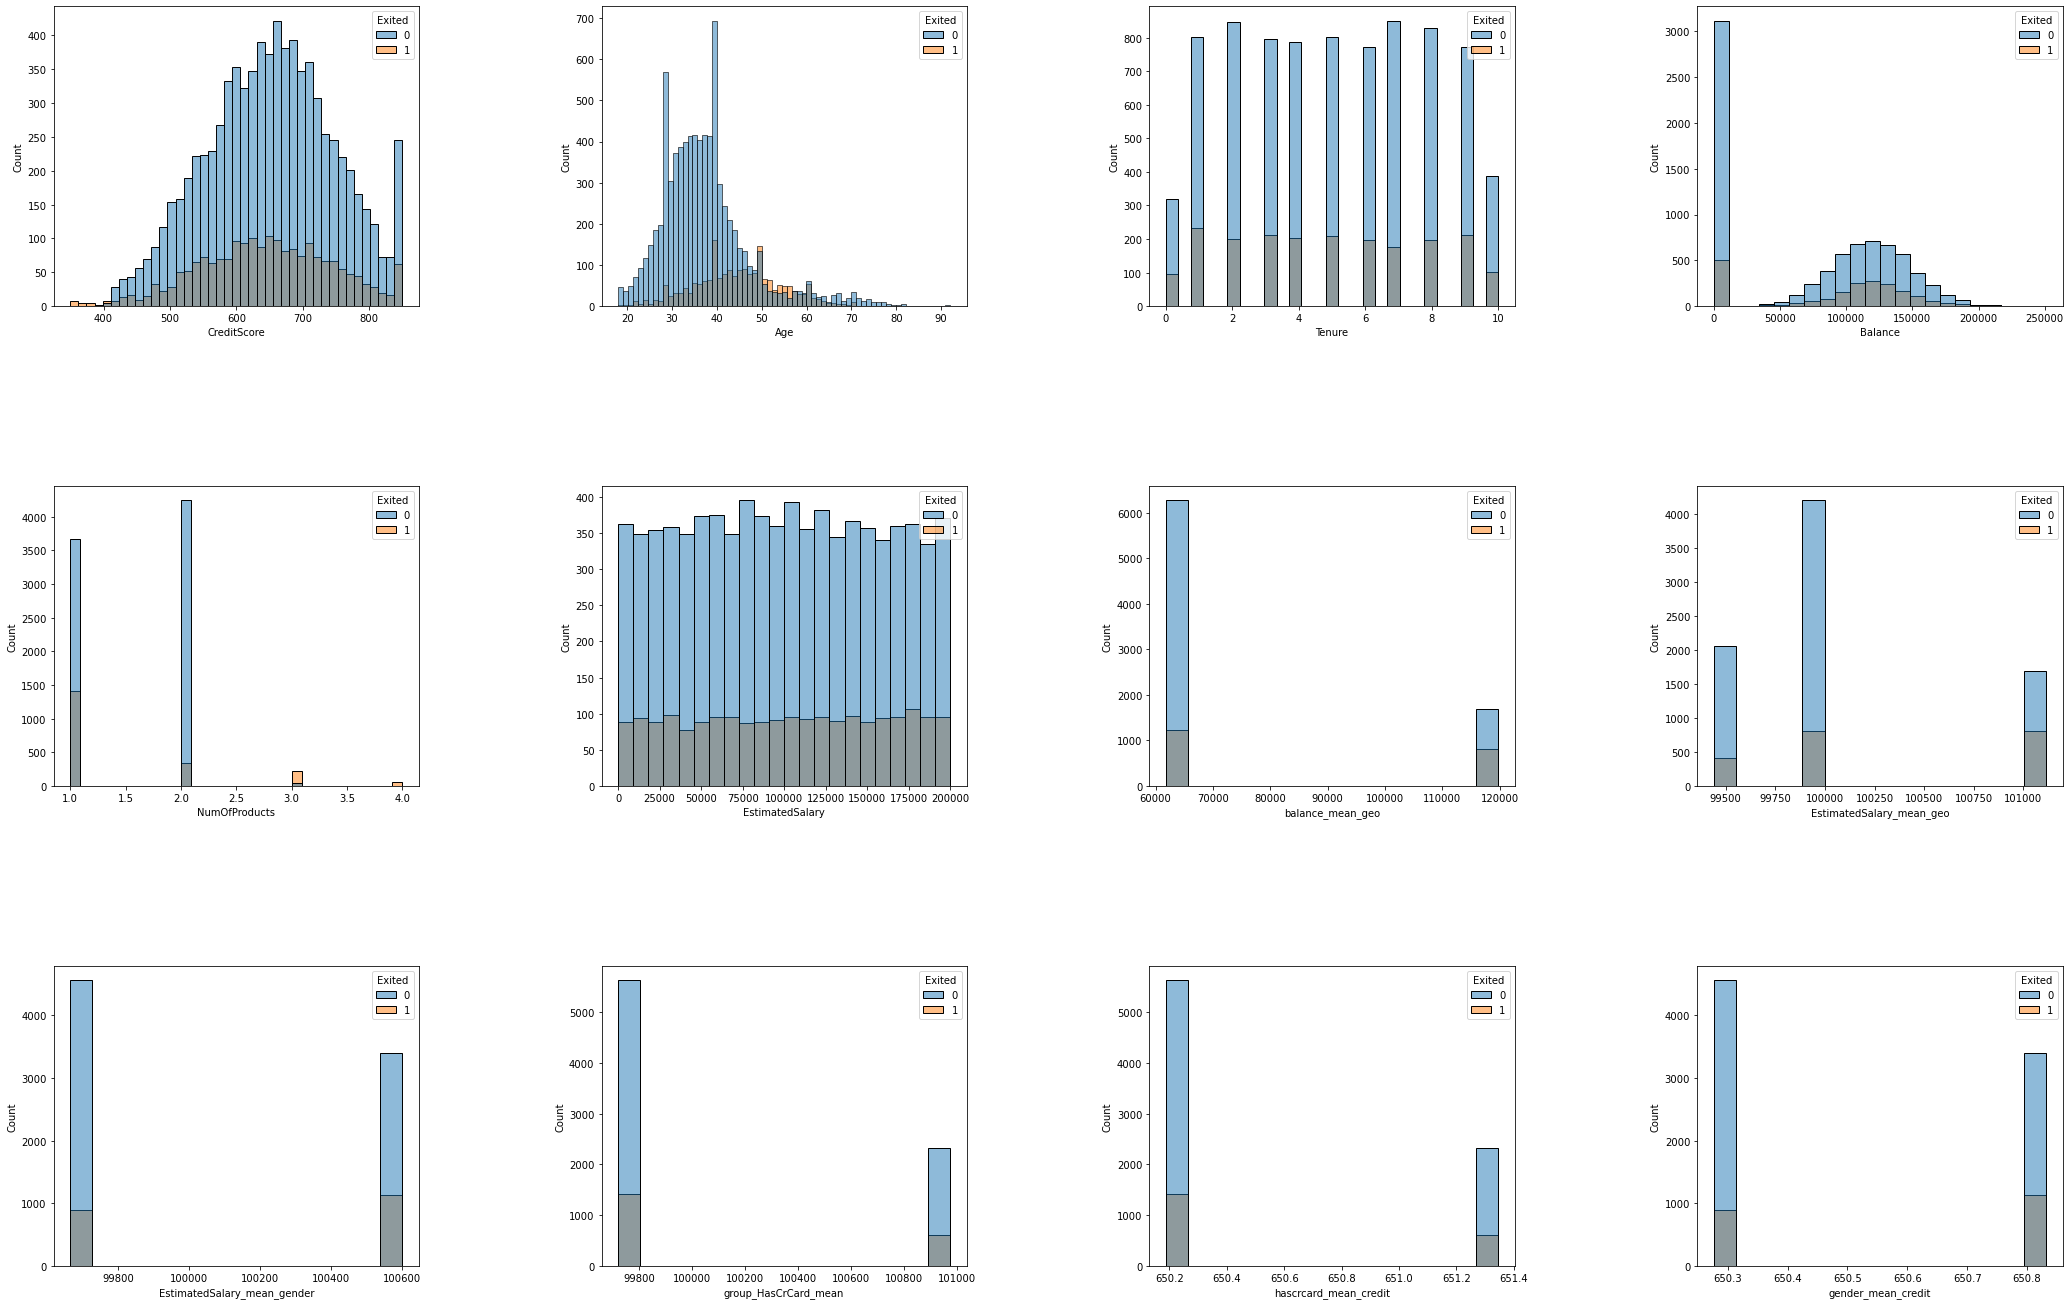

In [36]:
# Antes do feature eng
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
#variables.remove('RowNumber'), variables.remove('CustomerId')

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in dataset[variables].columns[:len(variables)-1]:
    plt.subplot(4, 4, n)
    _ = sns.histplot(data = dataset, x=column, hue='Exited')
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- Confirmamos a tendência de maior churn entre clientes com maior idade.
- Observamos também muitos clientes com 'balance' igual a zero, porém seme uma concetração atipica de casos de churn
- Distribuições proximas da normal com um skew fraco.

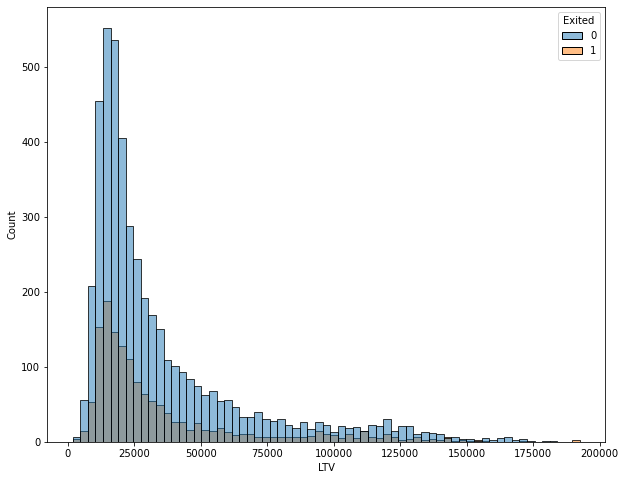

In [37]:
# LTV
LTV = dataset.loc[(dataset['LTV'] != 0) & (dataset['LTV'] < (0.3*1000000)),]

plt.figure(figsize=(10, 8))
sns.histplot(data = LTV, x='LTV', hue='Exited')
plt.show()

- Distribuição com forte skew. Iremos proceder com normalização dos dados na etapa de Feature Eng.

## 5.2 Análise Multivariada

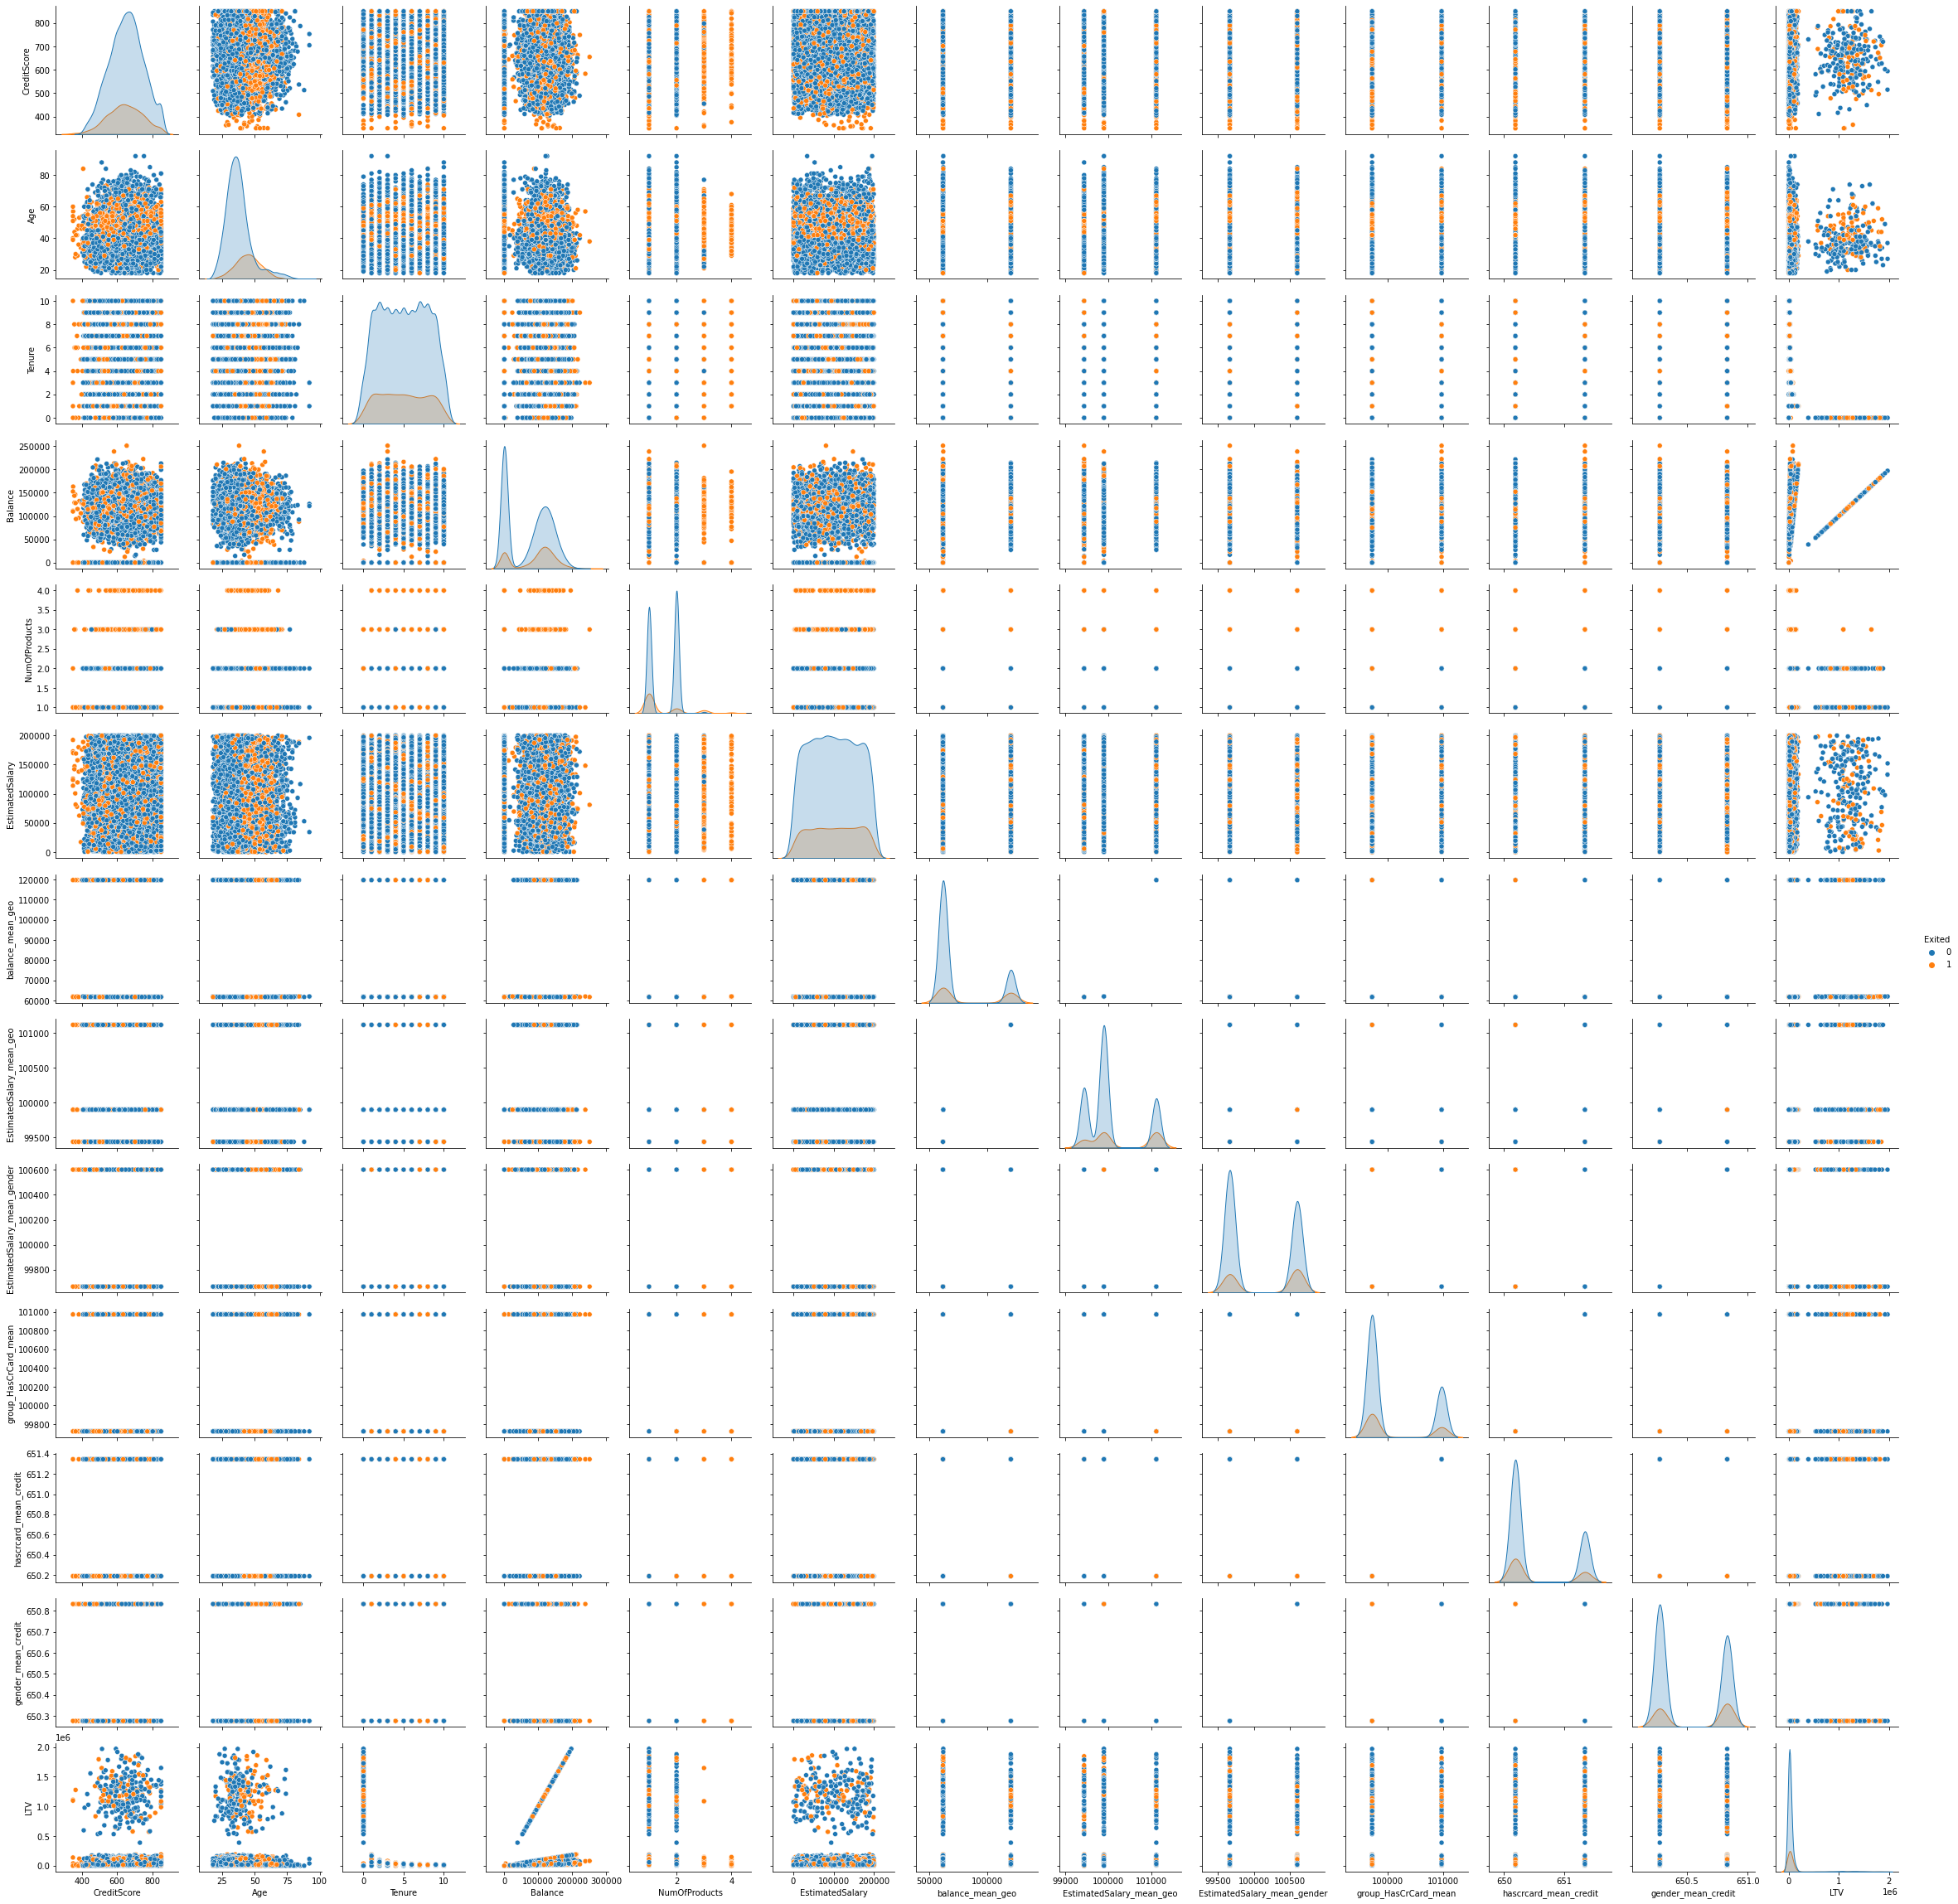

In [38]:
# Variáveis
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()
variables.append('Exited')

sns.pairplot(dataset[variables], hue='Exited')

- Não é possível observar nenhuma relação linear entre as variáveis.
- É possivel também notar uma concentração de casos de churn no NumOfProducts igual a 3. 

### Correlations

##### Variáveis Numericas

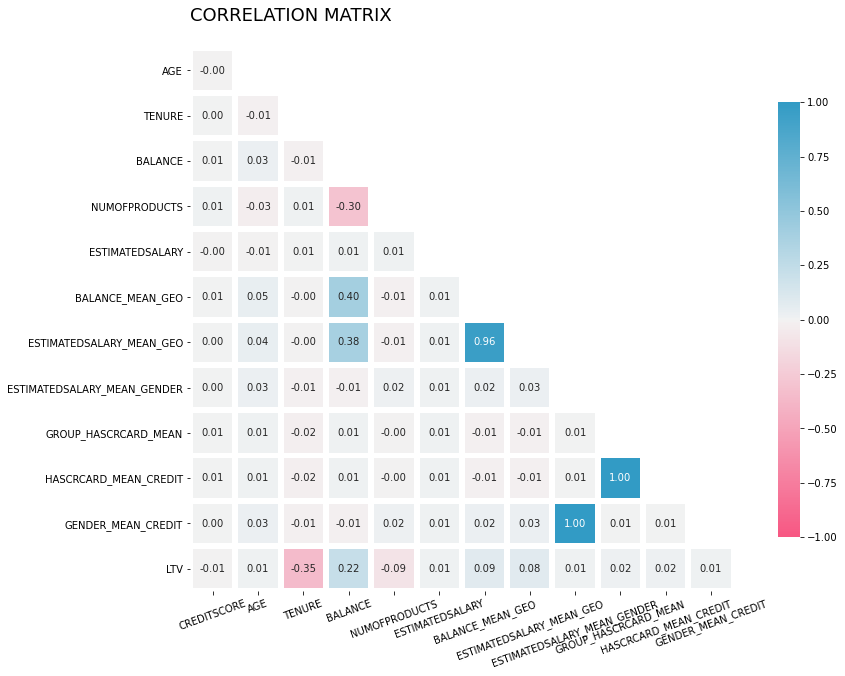

In [39]:
# Pearson correlation Matrix
Myheat_map(dataset =dataset, variaveis=variables)

- Observamos uma grande correlação entre a variável ESTIMATEDSALARY_MEAN_GEO e ESTIMATEDSALARY entre HASCARD_MEAN_CREDIT E ESTIMATEDSALARY_MEAN_GENDER e entre GENDER_MEAN_CREDIT E ESTIMATEDSALARY_MEAN_GEO         iremos excluir uma de cada par.

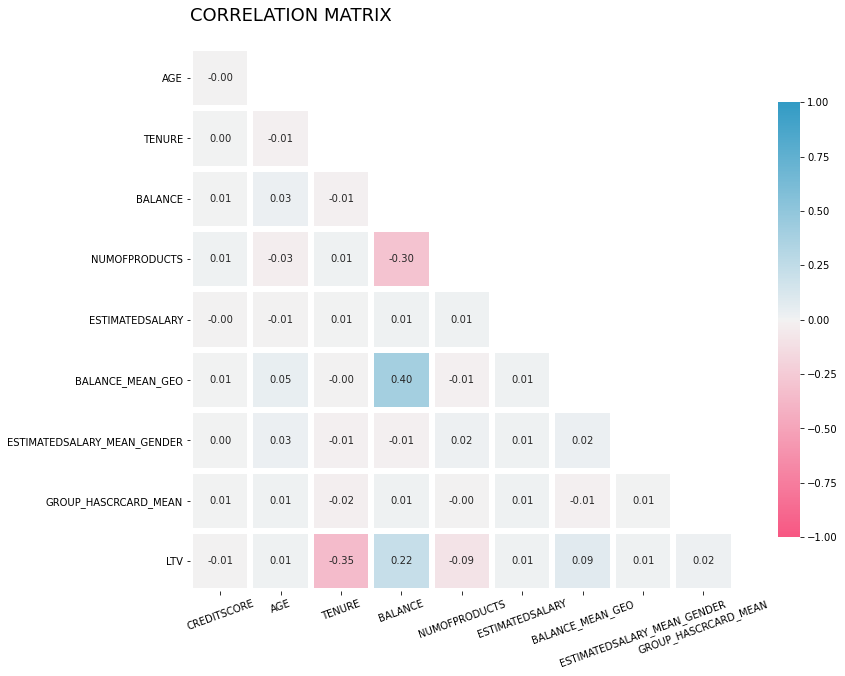

In [45]:
# Removendo a variável mean_x
var_list = ['EstimatedSalary_mean_geo','hascrcard_mean_credit', 'gender_mean_credit']

for var in var_list:
    variables.remove(var)
Myheat_map(dataset =dataset, variaveis=variables)

Text(0.5, 1.0, 'Pointbiserialr')

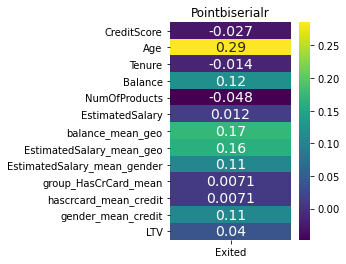

In [46]:
# Numericas com relação a target
variables = dataset.select_dtypes(['int64','float64']).columns.to_list()

# Correlações
corrs = [pointbiserialr(dataset['Exited'], dataset[var])[0] for var in variables]
df_corr = pd.DataFrame({'Exited': corrs}, index=variables)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

- Nenhuma variável com a correlação significante  com relação a variávl Target.

### Variáveis categoricas - cramers v

In [52]:
cols

['Geography',
 'Gender',
 'HasCrCard',
 'IsActiveMember',
 'Exited',
 'kmeans_group',
 'HasCrCard',
 'Exited']

Text(0.5, 1.0, 'Cramér V')

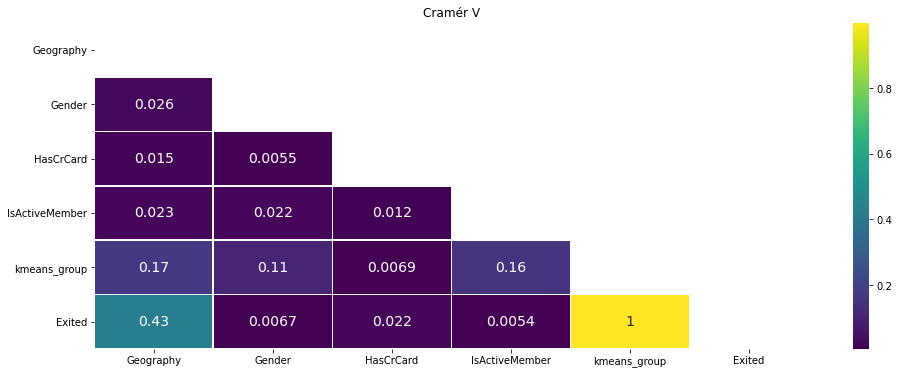

In [54]:
# colunas
cols = dataset.select_dtypes(['category', 'object']).columns.to_list()

# Dicionário para registro das correlações
dictt = {
        'Geography': [],
        'Gender': [],
        'HasCrCard': [],
        'IsActiveMember': [],
        'kmeans_group': [],
        'Exited': []
        }

for col in cols:
    for col1 in cols:
        corr = cramer_v(dataset[col], dataset[col1])
        dictt[col].append(corr)
        
# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

- Não encontramos nenhuma variável com alta correlação. Estou considerando correlações acima de 0.6 seriam eliminadas.

# 6.0 Teste de Hipóteses

 - H1 - O 'Balance' é maior acima de 30 anos de idade.
 - H2 - O 'Balance' é maior entre os clientes homens que mulheres.
 - H3 - O 'EstimatedSalary' é maior entre clientes homens que mulheres.
 - H4 - O 'EstimatedSalary' é maior acima de 30 anos de idade.
 - H5 - O churn é maior entre os menbros inativos que os ativos.

## H1 - O 'Balance' é maior acima de 30 anos de idade.

ho - Não a diferença entre o 'Balance' abaixo de 30anos e acima de 30anos.

h1 - Existe diferença entre o 'Balance' abaixo de 30anos e acima de 30anos.

In [55]:
# Dados
dados_h1_over = churn.loc[churn['Age']>30,'Balance']
dados_h1_under = churn.loc[churn['Age']<30,'Balance']

# Testando Hiposteses
print(f'Média over 30anos: {dados_h1_over.mean()}\n')
print(f'Média under 30anos: {dados_h1_under.mean()}\n')
hipo_test(dados_h1_over, dados_h1_under)

Média over 30anos: 77291.30045194198

Média under 30anos: 73698.71863497881

O valor de p é: 0.03368107075217667
Provável haver diferença


(2.124171943321777, 0.03368107075217667)

Provável haver diferença com os 'Balances' sendo maiores entre os clientes com mais de 30 anos de idade. Hipótese nula pode ser rejeitada.

## H2 - O 'Balance' é maior entre os clientes homens que mulheres.

ho - Não a diferença entre o 'Balance' abaixo de 30anos e acima de 30anos.

h1 - Existe diferença entre o 'Balance' abaixo de 30anos e acima de 30anos.

In [56]:
# Dados
dados_h2_male = churn.loc[churn['Gender']=='Male','Balance']
dados_h2_female = churn.loc[churn['Gender']=='Female','Balance']

# Testando Hipoteses
print(f'Média para Homens: {dados_h2_male.mean()}\n')
print(f'Média para Mulheres: {dados_h2_female.mean()}\n')
hipo_test(dados_h2_male, dados_h2_female)

Média para Homens: 77173.97450613906

Média para Mulheres: 75659.36913933513

O valor de p é: 0.22683580909200307
Provável que não haja diferença


(1.2086242759422712, 0.22683580909200307)

Pareçe não haver diferença entre homens e mulheres. Hipótese nula não pode ser rejeitada.

## H3 - O 'EstimatedSalary' é maior entre clientes homens que mulheres.

ho - Não a diferença entre o 'EstimatedSalary' para Homens e Mulheres

h1 - Existe diferença entre o 'EstimatedSalary' abaixo de 30anos e acima de 30anos.

In [57]:
# Dados
dados_h3_male = churn.loc[churn['Gender']=='Male','EstimatedSalary']
dados_h3_female = churn.loc[churn['Gender']=='Female','EstimatedSalary']

# Testando Hipoteses
print(f'Média para Homens: {dados_h3_male.mean()}\n')
print(f'Média para Mulheres: {dados_h3_female.mean()}\n')
hipo_test(dados_h3_male, dados_h3_female)

Média para Homens: 99664.57693054806

Média para Mulheres: 100601.54138234648

O valor de p é: 0.4172819312945406
Provável que não haja diferença


(-0.8111794562250657, 0.4172819312945406)

Provável que não haja diferença apesar da media (absolutamente) para mulheres ser maior. Hipótese nula não pode ser rejeitada. 

## H4 - O 'EstimatedSalary' é maior acima de 30 anos de idade.

In [58]:
# Dados
dados_h4_over = churn.loc[churn['Age']>30,'EstimatedSalary']
dados_h4_under = churn.loc[churn['Age']<30,'EstimatedSalary']

# Testando Hiposteses
print(f'Média over 30anos: {dados_h4_over.mean()}\n')
print(f'Média under 30anos: {dados_h4_under.mean()}\n')
hipo_test(dados_h4_over, dados_h4_under)

Média over 30anos: 99845.27874626478

Média under 30anos: 100855.24781840346

O valor de p é: 0.5161234476415246
Provável que não haja diferença


(-0.6493564187406714, 0.5161234476415246)

Provável que não haja diferença apesar da media (absolutamente) para clientes abaixo de 30 ser maior. Hipótese nula não pode ser rejeitada. 

## H5 - O churn é maior entre os membros inativos que os ativos.[TRUE]

In [63]:
dados_h5_nchurn = churn.loc[churn['Exited']==0,'IsActiveMember'].astype('int')
dados_h5_churn  = churn.loc[churn['Exited']==1,'IsActiveMember'].astype('int')

# Testando Hiposteses
print(f'Média para a classe 0: {dados_h5_nchurn.sum()}\n')
print(f'Média para a classe 1: {dados_h5_churn.sum()}\n')
hipo_test(dados_h5_nchurn, dados_h5_churn)

Média para a classe 0: 4416

Média para a classe 1: 735

O valor de p é: 1.348268516485762e-55
Provável haver diferença


(15.80508761104082, 1.348268516485762e-55)

Provável haver diferença com a classe 0 havendo a maior incidencia do evento churn dessa forma a inatividade do cliente pode levar ao churn. 

# 7.0 Split de Dados

In [11]:
# X e y
X = dataset.drop('Exited', axis=1)
y = dataset['Exited']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1)

# Alterando os tipos da Geography e Gender
varr = ['Geography', 'Gender']
for var in varr:
    Xtrain[var] = Xtrain[var].astype('category')
    Xtest[var] = Xtest[var].astype('category')

# Alterando o tipo dos ys
ytrain = ytrain.astype('int64')
ytest = ytest.astype('int64')

# 8.0 Data Preparation

In [12]:
# Ordinal Encoder
variaveis_category = Xtrain.select_dtypes('category')

# Instanciando o Ordinal Encoder
enc = OrdinalEncoder()

for var in variaveis_category:
    Xtrain[var] = enc.fit_transform(np.array(Xtrain[var]).reshape(-1,1))
    Xtest[var] = enc.transform(np.array(Xtest[var]).reshape(-1,1))

# RobustScaler
variaveis_numerical = Xtrain.select_dtypes(['int64','float64'])

# Instanciando o Robust Scaler
scaler = RobustScaler()

for var in variaveis_numerical:
    Xtrain[var] = scaler.fit_transform(np.array(Xtrain[var]).reshape(-1,1))
    Xtest[var] = scaler.transform(np.array(Xtest[var]).reshape(-1,1))

## 8.1 Balanciamento dos dados

In [15]:
# Adicionando balanciamento de dados ao Pipeline

# Instanciando o balanciador
smt = SMOTETomek(sampling_strategy='minority' ,random_state=42)
Xtrain_smt, ytrain_smt = smt.fit_resample(Xtrain, ytrain)
#Xtest_smt, ytest_smt = smt.fit_resample(Xtest, ytest)

<AxesSubplot:xlabel='Exited', ylabel='count'>

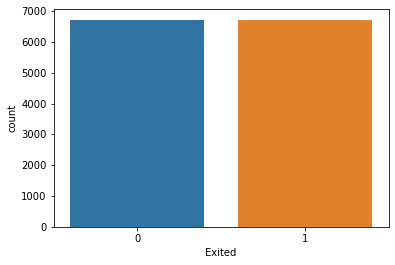

In [16]:
sns.countplot(x='Exited', data=pd.DataFrame(ytrain_smt))

# 9.0 Feature Selection

In [21]:
# Modelo
model = lgb.LGBMClassifier()

#Selecionador de Features
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True, )

Feature_Selector.fit(X=Xtrain_smt,y=ytrain_smt, n_trials=10, random_state=1)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

8 attributes confirmed important: ['Age', 'Gender', 'balance_mean_geo', 'NumOfProducts', 'IsActiveMember', 'Balance', 'EstimatedSalary', 'Tenure']
7 attributes confirmed unimportant: ['group_HasCrCard_mean', 'EstimatedSalary_mean_gender', 'kmeans_group', 'hascrcard_mean_credit', 'HasCrCard', 'gender_mean_credit', 'EstimatedSalary_mean_geo']
3 tentative attributes remains: ['CreditScore', 'Geography', 'LTV']


In [22]:
# Visualizando as variáveis selecioandas
X_subset = Feature_Selector.Subset()
X_subset.head()

,Age,Gender,balance_mean_geo,NumOfProducts,IsActiveMember,Balance,EstimatedSalary,Tenure
0,1.636364,0.0,0.000000,0.0,1.0,-0.759035,0.061830,-0.6
1,-1.000000,-1.0,-1.000000,1.0,0.0,-0.759035,0.126286,0.4
2,-0.545455,0.0,80.840557,1.0,0.0,0.352616,-0.756808,-0.2
3,1.545455,-1.0,-1.000000,0.0,1.0,-0.759035,0.518091,0.0
4,-0.181818,0.0,80.840557,1.0,1.0,0.220711,0.494581,-0.8


# 10.0 Model Selection

Comparando as a performance dos modelos, utilizando todas as variáveis contra utilizando somente as variáveis selecionadas pelo BorutaShap. Podemos observar que a melhor performance foi obtida pelo RandomForest além da de ter curvas de aprendizado convergindo de forma "comportada".

Iremos seguir com o RandomForest, treinaremos também versões da lightGBM por ser um algoritmo de treinamento mais rapido e de boa performance, caso o RandomForest seja muito demorado.   

A métrica base utilizada será o f1-score em conjunto com recall. A principal razão é por estarmos trabalhando com um problema de binário cujo o evento alvo é raro, dessa forma, queremos ter alta capacidade de detecção do evento alvo (recall) sem incorrer um muitos erros de previsão da classe negativa(F1 score nos ajuda nessa parte).

Lembrando
F1 score é média harmonica da recall e da precision.
Recall é a taxa de detecção de uma determinada classe.

## Com todas as variáveis

,LR,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.726932,0.744522,0.858847,0.912357,0.884634,0.885677


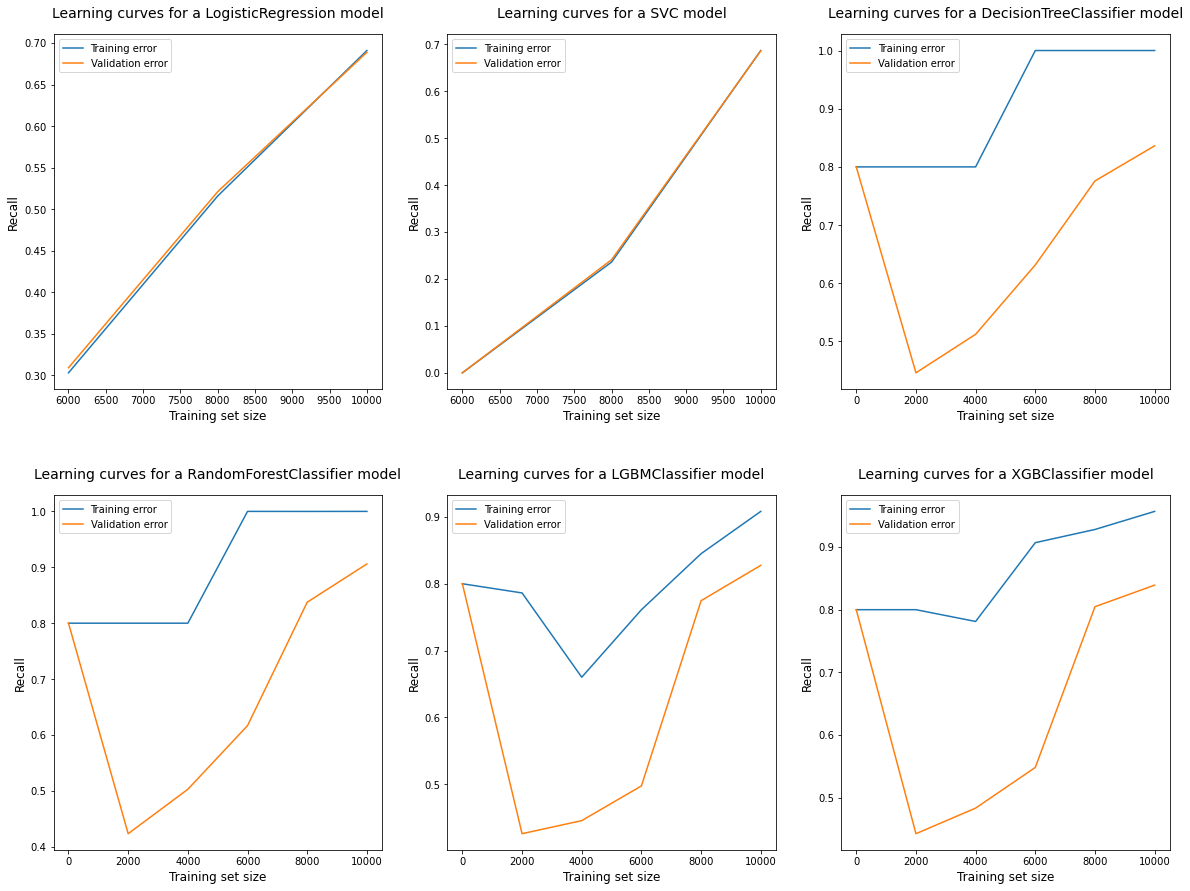

In [25]:
# Excluindo variáveis com alta correlação
Xtrain_smt_new = Xtrain_smt.drop(['EstimatedSalary_mean_geo','hascrcard_mean_credit', 'gender_mean_credit'], axis=1)

# Selicionando o modelo a ser trabalhado. 
model_selection(Xtrain_smt_new, ytrain_smt)

## Com as variáveis selecionadas pelo Boruta.

,LR,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.727081,0.747204,0.848413,0.889253,0.880759,0.885976


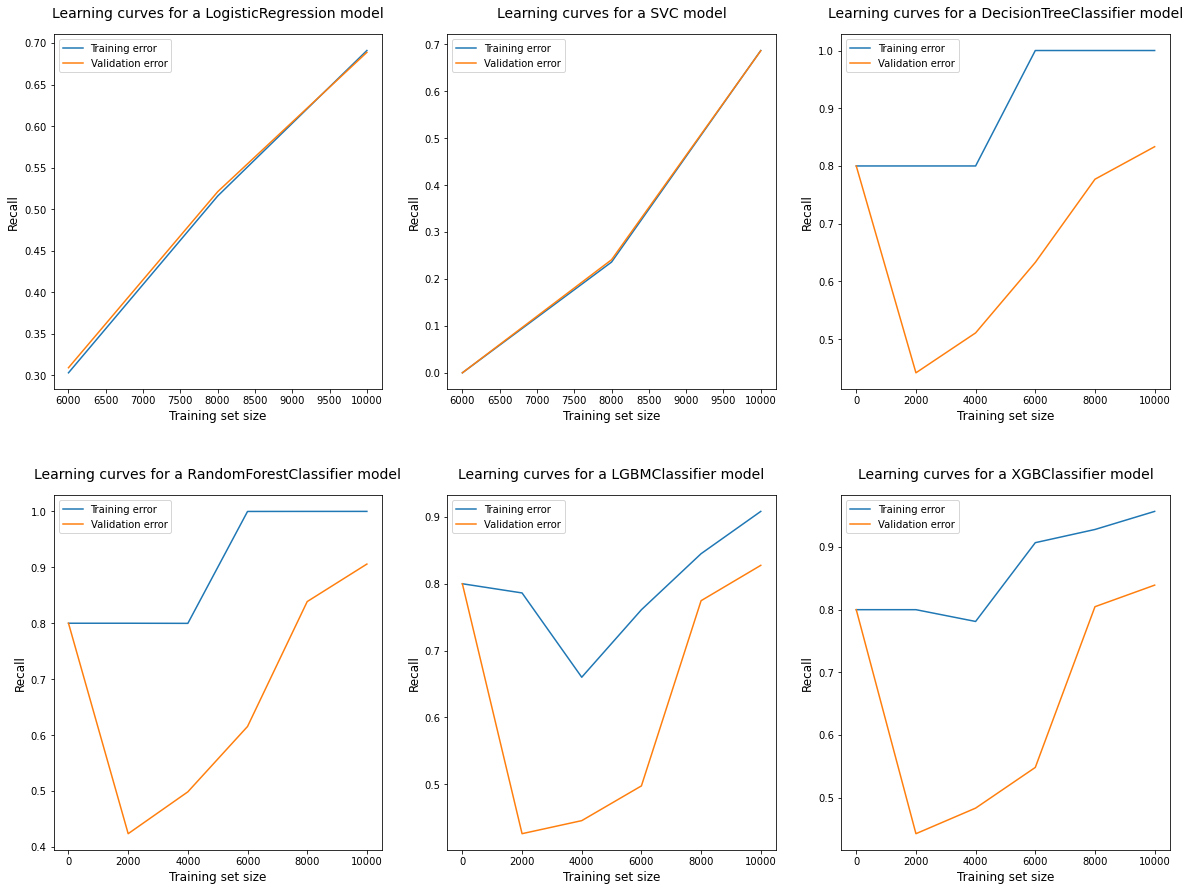

In [26]:
# Selecionando o modelo a ser trabalhado
model_selection(X_subset, ytrain_smt)

## Com as variáveis selecionadas pelo Boruta mais as variáveis de tentativa.

,LR,SVM,DecisionTree,RandomForestClassifier,LGBM,XGBOOST
0,0.727081,0.747204,0.849606,0.889551,0.880759,0.885976


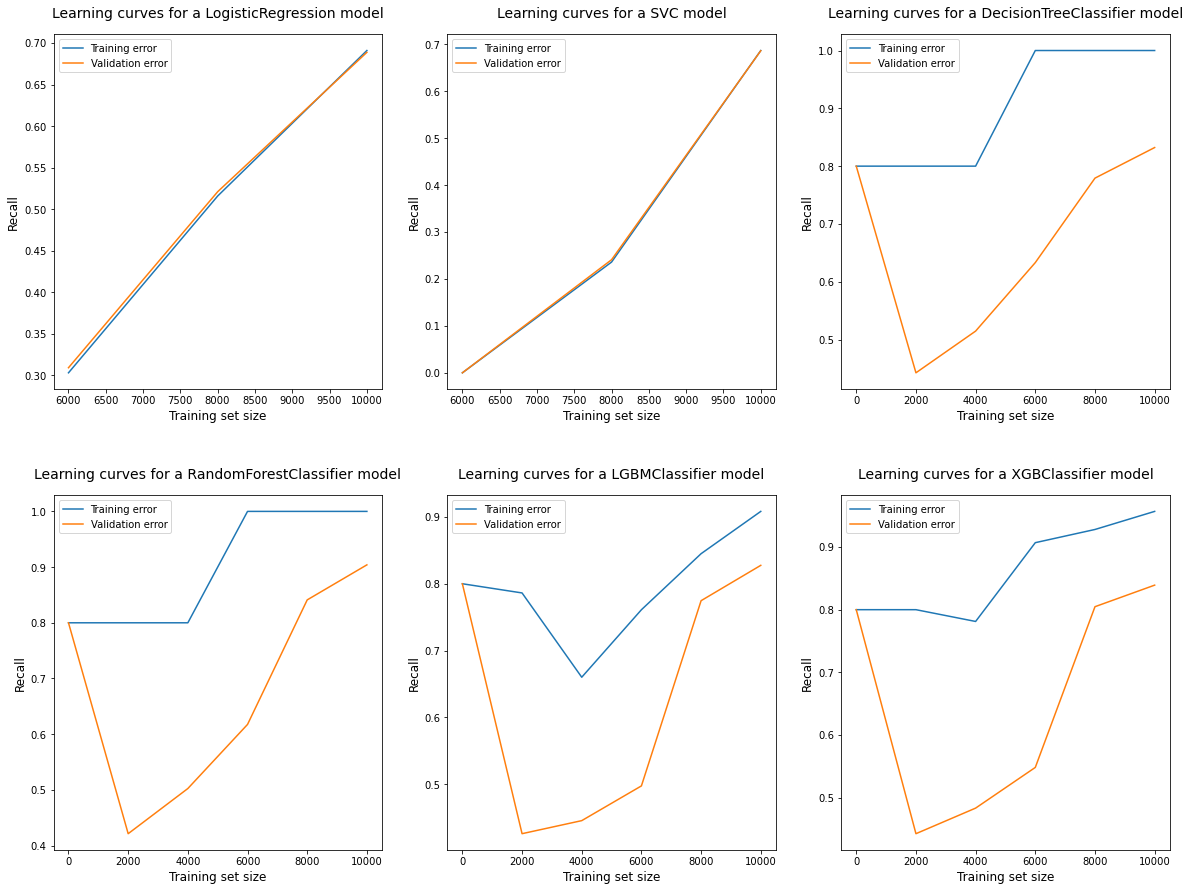

In [27]:
# Criando lista com as variáveis
colunas = X_subset.columns.to_list()
colunas.append('CreditScore'), colunas.append('Geography'), colunas.append('LTV')

# 
Xtrain_new = Xtrain_smt[colunas]

# Selecionando o modelo a ser trabalhado
model_selection(X_subset, ytrain_smt)

# 11.0 Tunning/Treinamento do modelo

### Tunning-LGBM

** LGBM: **

O que é LGBM?

De acordo com a documentação adequada do LightGBM, é uma estrutura de aumento de gradiente que usa algoritmos de aprendizagem baseados em árvore. Ele é projetado para ser distribuído e eficiente com as seguintes vantagens:

- Maior velocidade de treinamento e maior eficiência.

- Menor uso de memória.

- Melhor precisão.

- Suporte para aprendizagem paralela e GPU.

- Capaz de lidar com dados em grande escala.

A principal diferença do LightGBM em comparação com outros algoritmos baseados em árvore é que ele faz a árvore crescer de forma vertical (folha) em vez de horizontal (nível). Ele escolherá a folha com perda máxima de delta para crescer e continuar crescendo a mesma folha; normalmente, um algoritmo Leaf-wise pode reduzir mais perdas do que um algoritmo-wise.

Os diagramas abaixo podem fornecer uma compreensão mais visual:

Restrições: Normalmente, o LightGBM não funciona bem em pequenos conjuntos de dados, não há limite formal aqui, mas 10.000 instâncias seria um bom número.

Parâmetros principais:

profundidade máxima,
boosting_type,
taxa de Aprendizagem,
n_estimators,
num_leaves,
subamostra,
min_split_gain,
min_split_weight,
min_child_samples.

In [17]:
%%time
# Grid de Parametros
param_grid = {
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [100, 250, 500,1000],
              'num_leaves': [10, 15, 31, 45, 70],
              'min_child_samples' : [5,10,20, 50]
             }

# cross-validiação
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def tunnig_gridsearch(Xtrain, ytrain, model, param_grid, cv, scoring, refit):
    
    
    search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring=scoring,
                          refit=refit,
                          cv=cv,
                          verbose=1,
                          n_jobs=-1)
    
    search.fit(Xtrain, ytrain)
    
    return search.best_params_, search.cv_results_

# Tunning
best_params, cv_results = tunnig_gridsearch(Xtrain=Xtrain_smt,
                                             ytrain=ytrain_smt,
                                             model=lgb.LGBMClassifier(),
                                             param_grid=param_grid,
                                             scoring='recall',
                                             refit='recall',
                                             cv=skf)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  2.5min finished


CPU times: user 22.8 s, sys: 625 ms, total: 23.4 s
Wall time: 2min 29s


In [18]:
# best parameters
best_params

{'learning_rate': 0.5,
 'min_child_samples': 10,
 'n_estimators': 250,
 'num_leaves': 70}

### Tunning-Random Forest

**RandomForest:**

**What is Random Forest?**

Random Forest is a set of Decision Trees that are built and can be used for regression or classification tasks (our case). To better understand Random Forest we will quickly understand what Bagging is.

Bagging:
An isolated decision tree has a high variance, however, if we build several Decision Trees based on random samples taken from our dataset and average the predictions for each sample, we considerably reduce the variance of our forecasts. This process is called Bagging.

The formula being:


$$ 
fbag(x) = \frac {1}{b}\sum f^b(x) 
$$


By reducing the variance through the average of several Decision Trees we were able to increase the accuracy of the model.

** How does Random Forest work? **

The difference between Random Forest and Bagging is at the time of each split, in the case of Random Forest, the algorithm randomly chooses m predictors from the total p predictors of the dataset, so the algorithm cannot consider all the predictors for each tree built.

$$ 
m =\sqrt[2]{p} 
$$


What is the reason for this? In order to avoid, as in Bagging, if the dataset has a very strong predictor, all trees will be built equally, using this predictor as the main 'split'.
Random Forests avoid this problem by forcing the algorithm to work with only part of the predictors.

**Pros:**

From decision trees, we can identify more significant movies, as well as the relationship between the variables

Easy to understand, the visualization of the tree is easy to understand, especially when communicating the analysis process to the business areas, since it does not require any statistical knowledge to be read and interpreted.

They do not presuppose the distribution of space or the structure of the classifier, nor are they restricted to data types, being able to manipulate categorical or numerical types.


**Cons:**

Overfitting is one of the biggest difficulties for decision tree models. This problem is solved by defining
restrictions on the model and tunning parameters (pruning).

Not suitable for continuous variables, the decision tree loses information when it categorizes variables in different categories.


In [30]:
%%time
# Grid de Parametros
param_grid = {
              'max_depth': [10, 15, 31, 45],
              'n_estimators': [100, 250, 500, 1000],
              'min_samples_split' : [5,10,20, 30]
             }

# cross-validiação
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def tunnig_gridsearch(Xtrain, ytrain, model, param_grid, cv, scoring, refit):
    
    
    search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring=scoring,
                          refit=refit,
                          cv=cv,
                          verbose=1,
                          n_jobs=-1)
    
    search.fit(Xtrain, ytrain)
    
    return search.best_params_, search.cv_results_

# Tunning
best_params_random, cv_results = tunnig_gridsearch(Xtrain=Xtrain_smt,
                                                   ytrain=ytrain_smt,
                                                   model=RandomForestClassifier(n_jobs=-1),
                                                   param_grid=param_grid,
                                                   scoring='recall',
                                                   refit='recall',
                                                   cv=skf)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.8min finished


CPU times: user 25.9 s, sys: 627 ms, total: 26.5 s
Wall time: 2min 52s


In [31]:
# best parameters
best_params_random

{'max_depth': 31, 'min_samples_split': 5, 'n_estimators': 1000}

## Treinando LGBM

In [19]:
def train_tunned_lightGBM(X, y, 
                          learning_rate,
                          min_child_samples, 
                          n_estimators, 
                          num_leaves, 
                          n_iter, 
                          n_splits=10):

    model = lgb.LGBMClassifier(objective='binary',
                               learning_rate = learning_rate,
                               min_child_samples = min_child_samples,
                               n_estimators = n_estimators,
                               num_leaves = num_leaves
                               )

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'KAPPA_MEAN': [],
                  'KAPPA_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': [] }
    
    # cross-validiação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    # resultado
    acc = []
    kappa = []
    recall = []
    f1 = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        model.fit(X_treino, y_treino)
        pred = model.predict(X_valid)
        Acc = accuracy_score(y_valid, pred, normalize=True)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred, pos_label=1, average='binary')
        F1 = f1_score(y_valid, pred, pos_label=1, average='binary')
        Precision = precision_score(y_valid, pred, pos_label=1, average='binary')
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)
        f1.append(F1)
        precision.append(Precision)

    resultados['ACC_MEAN'].append(np.mean(acc))
    resultados['ACC_STD'].append(np.std(acc))
    resultados['KAPPA_MEAN'].append(np.mean(kappa))
    resultados['KAPPA_STD'].append(np.std(kappa))
    resultados['RECALL_MEAN'].append(np.mean(recall))
    resultados['RECALL_STD'].append(np.std(recall))
    resultados['F1_MEAN'].append(np.mean(f1))
    resultados['F1_STD'].append(np.std(f1))
    resultados['PRECISION_MEAN'].append(np.mean(precision))
    resultados['PRECISION_STD'].append(np.std(precision))

    # retrain over all data
    model = model.fit(X, y)
    
    # Salvando o modelo em pickle
    with open('models/modelo_tunned_lgbm.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Painel
    painel_df = pd.DataFrame(resultados).T
    return painel_df, model

# Treinando modelo tunnado
painel, modelo_tunned_lgbm = train_tunned_lightGBM(X=Xtest, 
                                              y=ytest,
                                              learning_rate=best_params['learning_rate'],
                                              min_child_samples=best_params['min_child_samples'], 
                                              n_estimators=best_params['n_estimators'] , 
                                              num_leaves=best_params['num_leaves'],   
                                              n_iter=5)

# painel de metricas
painel

,0
ACC_MEAN,0.847930
ACC_STD,0.024087
KAPPA_MEAN,0.460124
KAPPA_STD,0.076036
RECALL_MEAN,0.472515
RECALL_STD,0.054986
F1_MEAN,0.548383
F1_STD,0.061977
PRECISION_MEAN,0.662671
PRECISION_STD,0.106665


Podemos observar que obtemos um recall de 0.88 com um F1 0.91.

## Treinando RandomForest

In [33]:
def train_tunned_random(X, y, 
                        max_depth,
                        n_estimators,
                        min_samples_split,
                        n_iter, 
                        n_splits=10):

    model = RandomForestClassifier(max_depth = max_depth,
                                   n_estimators = n_estimators,
                                   min_samples_split = min_samples_split)

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'KAPPA_MEAN': [],
                  'KAPPA_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': [] }
    
    # cross-validiação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    # resultado
    acc = []
    kappa = []
    recall = []
    f1 = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        model.fit(X_treino, y_treino)
        pred = model.predict(X_valid)
        Acc = accuracy_score(y_valid, pred, normalize=True)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Recall = recall_score(y_valid, pred, pos_label=1, average='binary')
        F1 = f1_score(y_valid, pred, pos_label=1, average='binary')
        Precision = precision_score(y_valid, pred, pos_label=1, average='binary')
        acc.append(Acc)
        kappa.append(Kappa)
        recall.append(Recall)
        f1.append(F1)
        precision.append(Precision)

    resultados['ACC_MEAN'].append(np.mean(acc))
    resultados['ACC_STD'].append(np.std(acc))
    resultados['KAPPA_MEAN'].append(np.mean(kappa))
    resultados['KAPPA_STD'].append(np.std(kappa))
    resultados['RECALL_MEAN'].append(np.mean(recall))
    resultados['RECALL_STD'].append(np.std(recall))
    resultados['F1_MEAN'].append(np.mean(f1))
    resultados['F1_STD'].append(np.std(f1))
    resultados['PRECISION_MEAN'].append(np.mean(precision))
    resultados['PRECISION_STD'].append(np.std(precision))

    # retrain over all data
    model = model.fit(X, y)
    
    # Salvando o modelo em pickle
    with open('models/modelo_tunned_random.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Painel
    painel_df = pd.DataFrame(resultados).T
    return painel_df, model

# Treinando modelo tunnado
painel, modelo_tunned_random = train_tunned_random(X=Xtest, 
                                              y=ytest,
                                              max_depth=best_params_random['max_depth'],
                                              n_estimators=best_params_random['n_estimators'], 
                                              min_samples_split=best_params_random['min_samples_split'],   
                                              n_iter=5)

# painel de metricas
painel

,0
ACC_MEAN,0.855456
ACC_STD,0.016109
KAPPA_MEAN,0.400466
KAPPA_STD,0.097967
RECALL_MEAN,0.360784
RECALL_STD,0.094537
F1_MEAN,0.471285
F1_STD,0.102842
PRECISION_MEAN,0.714737
PRECISION_STD,0.072877


Já utilizando o RandomForest, obtemos um recall de 0.89 frente ao 0.88 com LGBM , e um F1 de 0.917 frente a 0.911 com a LGBM.

# 12.0 Interpretação do Modelo

In [ ]:
# Importância das variáveis
from scikitplot.estimators import plot_feature_importances

# Variaveis
variaveis = Xtrain_smt.columns.to_list()

plt.figure(figsize=(16, 10))
plot_feature_importances(modelo_tunned_random, feature_names=variaveis, x_tick_rotation=90)
plt.show()

- Podemos observar que a variável 'Age' foi a variável mais relevante na modelagem do nosso problema. Sendo os 3 principais fatores abaixo:
       - Idade do cliente.
       - O número de Produtos.
       - E o Gender do cliente.

In [ ]:
%%time
# Shap values
import shap

f = plt.figure()
shap_values = shap.TreeExplainer(modelo_tunned_random).shap_values(Xtrain_attr)
shap.summary_plot(shap_values, Xtrain_attr )

In [ ]:
# Confusion Matrix
from scikitplot.metrics import plot_confusion_matrix


Xtest_smt = Xtest_smt[['Balance_new', 'Gender', 'IsActiveMember', 'Geography',
                       'EstimatedSalary', 'Age_new', 'EstimatedSalary_new', 'mean_x', 'Age',
                       'NumOfProducts', 'kmeans_group', 'Balance', 'Tenure_new', 'Tenure',
                       'CreditScore_new', 'CreditScore', 'mean_y', 'LTV']]

# Predictions
pred = modelo_tunned_random.predict(Xtest_smt)  #Xtest_smt, ytest_smt

# Plot
plot_confusion_matrix(ytest_smt, pred, normalize=True)

In [ ]:
# Learning Curves
from scikitplot.estimators import plot_learning_curve

#  Estrátegia de cross-validation 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


plot_learning_curve(modelo_tunned_random, Xtest_smt, ytest_smt, cv=skf, scoring='f1')
plt.show()

# 13.0 API

In [ ]:
# Example Data
test_data = churn.sample(5)

# Tunnig into a json
df_json = test_data.to_json(orient='records')
df_json

In [ ]:
type(df_json)

## API_Predictions

In [ ]:
url = 'http://0.0.0.0:5000/predict'
#url = 'https://pa001-app.herokuapp.com/predict'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)
r.json()